<a href="https://colab.research.google.com/github/2303a51884/2303a51884-pyds-b-02/blob/main/ieee_paper_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -------------------------------------------
# 0. IMPORT LIBRARIES
# -------------------------------------------
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# -------------------------------------------
# 1. CREATE SYNTHETIC DATASET
# -------------------------------------------
np.random.seed(42)

n_samples = 1100

df = pd.DataFrame({
    "Anxiety level": np.random.randint(5, 20, n_samples),
    "Depression": np.random.randint(5, 20, n_samples),
    "Sleep Quality": np.random.randint(1, 5, n_samples),
    "Academic performance": np.random.randint(1, 5, n_samples),
    "Study load": np.random.randint(1, 5, n_samples),
    "Social Support": np.random.randint(1, 5, n_samples),
})

# Synthetic stress level (target)
df["Stress level"] = (
    0.4 * df["Anxiety level"]
    + 0.3 * df["Depression"]
    - 0.25 * df["Sleep Quality"]
    + 0.2 * df["Study load"]
    - 0.1 * df["Social Support"]
    + np.random.normal(0, 2, n_samples)
)


# -------------------------------------------
# 2. PREPROCESS DATA
# -------------------------------------------
features = ["Anxiety level", "Depression", "Sleep Quality",
            "Academic performance", "Study load", "Social Support"]

X = df[features]
y = df["Stress level"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


# -------------------------------------------
# 3. RANDOM FOREST
# -------------------------------------------
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_rmse = sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)


# -------------------------------------------
# 4. XGBOOST
# -------------------------------------------
xgb = XGBRegressor(
    learning_rate=0.05,
    max_depth=8,
    n_estimators=400,
    subsample=0.8,
    objective="reg:squarederror"
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

xg_rmse = sqrt(mean_squared_error(y_test, xgb_pred))
xg_r2 = r2_score(y_test, xgb_pred)


# -------------------------------------------
# 5. STACKED ENSEMBLE
# -------------------------------------------
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

meta_X_train = np.column_stack((rf.predict(X_train),
                                xgb.predict(X_train),
                                gb.predict(X_train)))

meta_X_test = np.column_stack((rf_pred, xgb_pred, gb.predict(X_test)))

meta_model = LinearRegression()
meta_model.fit(meta_X_train, y_train)
stack_pred = meta_model.predict(meta_X_test)

stack_rmse = sqrt(mean_squared_error(y_test, stack_pred))
stack_r2 = r2_score(y_test, stack_pred)


# -------------------------------------------
# 6. LSTM MODEL
# -------------------------------------------

def create_lstm_data(data, labels, time_steps=3):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data[i:i+time_steps])
        ys.append(labels[i+time_steps])
    return np.array(Xs), np.array(ys)


time_steps = 3
X_lstm, y_lstm = create_lstm_data(X_scaled, y.values, time_steps)

X_train_lstm, X_test_lstm = train_test_split(X_lstm, test_size=0.2, random_state=42)
y_train_lstm, y_test_lstm = train_test_split(y_lstm, test_size=0.2, random_state=42)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_steps, X.shape[1])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.fit(X_train_lstm, y_train_lstm, epochs=25, batch_size=16, verbose=1)

lstm_pred = model.predict(X_test_lstm).flatten()
lstm_rmse = sqrt(mean_squared_error(y_test_lstm, lstm_pred))
lstm_r2 = r2_score(y_test_lstm, lstm_pred)


# -------------------------------------------
# 7. PRINT RESULTS
# -------------------------------------------
print("\n===== MODEL RESULTS =====")
print(f"Random Forest: RMSE={rf_rmse:.3f}, R²={rf_r2:.3f}")
print(f"XGBoost:       RMSE={xg_rmse:.3f}, R²={xg_r2:.3f}")
print(f"Stacked Model: RMSE={stack_rmse:.3f}, R²={stack_r2:.3f}")
print(f"LSTM Model:    RMSE={lstm_rmse:.3f}, R²={lstm_r2:.3f}")

Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 60.4189
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8452
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9472
Epoch 4/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8160
Epoch 5/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.3218
Epoch 6/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4745
Epoch 7/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.2173
Epoch 8/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.9658
Epoch 9/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.8765
Epoch 10/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.6214
Epoch 11/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.1560
Epoch 12/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.9170
Epoch 13/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4888
Epoch 14/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7893
Epoch 15/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3382
Epoch 16/25
55/55 ━━━━━━━━━━━


===== TABLE 1: FIRST 10 RECORDS =====
   Anxiety level  Depression  Sleep Quality  Academic performance  Study load  \
0             11           6              1                     3           4   
1              8          13              3                     4           1   
2             17          12              1                     2           4   
3             19          17              1                     1           1   
4             15          16              4                     4           2   
5             12          14              2                     2           1   
6             17          11              1                     2           1   
7              9          13              1                     1           2   
8             11           8              4                     1           1   
9             14          17              4                     3           4   

   Social Support  Stress level  
0               2      5.387530  
1

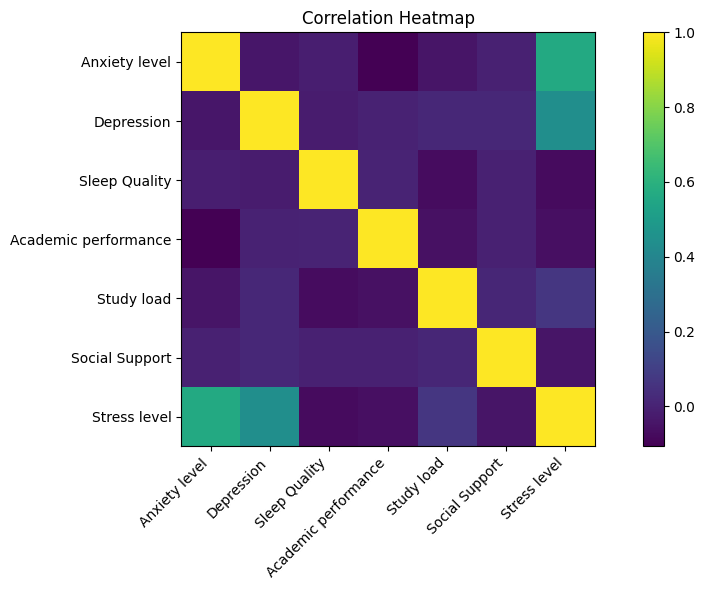

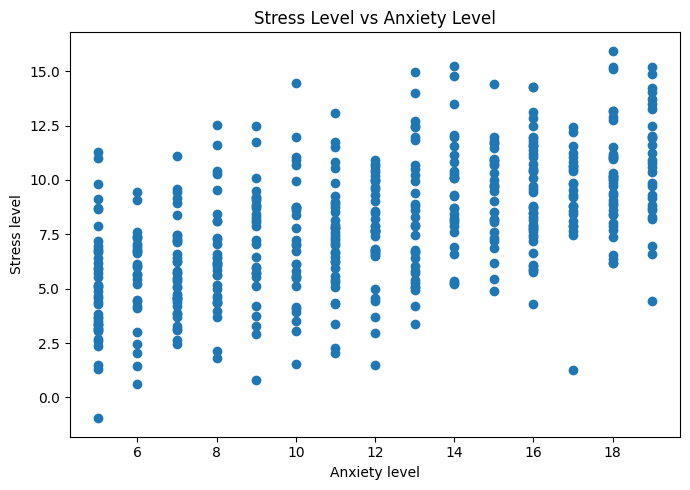

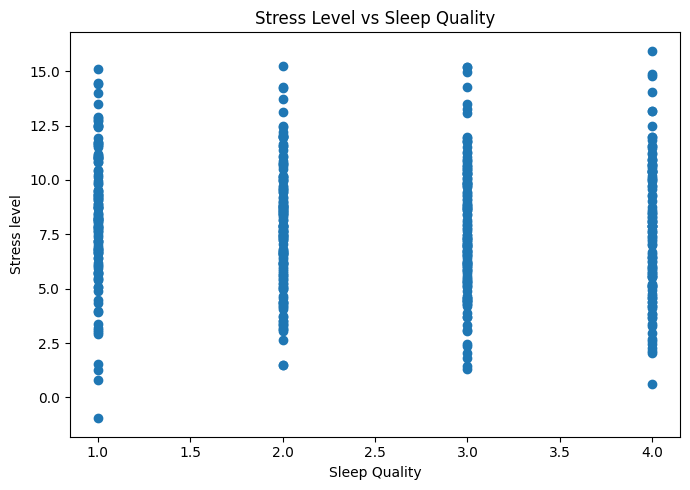

In [2]:
# -------------------------------------------
# IMPORT LIBRARIES
# -------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# -------------------------------------------
# GENERATE SYNTHETIC DATASET
# -------------------------------------------
np.random.seed(42)
n_samples = 500

df = pd.DataFrame({
    "Anxiety level": np.random.randint(5, 20, n_samples),
    "Depression": np.random.randint(5, 20, n_samples),
    "Sleep Quality": np.random.randint(1, 5, n_samples),
    "Academic performance": np.random.randint(1, 5, n_samples),
    "Study load": np.random.randint(1, 5, n_samples),
    "Social Support": np.random.randint(1, 5, n_samples),
})

# Synthetic Stress Level
df["Stress level"] = (
    0.4 * df["Anxiety level"]
    + 0.3 * df["Depression"]
    - 0.25 * df["Sleep Quality"]
    + 0.2 * df["Study load"]
    - 0.1 * df["Social Support"]
    + np.random.normal(0, 2, n_samples)
)

# -------------------------------------------
# TABLE 1: Sample Dataset Records
# -------------------------------------------
print("\n===== TABLE 1: FIRST 10 RECORDS =====")
print(df.head(10))

# -------------------------------------------
# TABLE 2: Summary Statistics
# -------------------------------------------
print("\n===== TABLE 2: SUMMARY STATISTICS =====")
print(df.describe())

# -------------------------------------------
# TABLE 3: Correlation Table
# -------------------------------------------
corr = df.corr()
print("\n===== TABLE 3: CORRELATION MATRIX =====")
print(corr)

# -------------------------------------------
# GRAPH 1: Correlation Heatmap
# -------------------------------------------
plt.figure(figsize=(10, 6))
plt.imshow(corr, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# -------------------------------------------
# GRAPH 2: Stress vs Anxiety
# -------------------------------------------
plt.figure(figsize=(7, 5))
plt.scatter(df["Anxiety level"], df["Stress level"])
plt.xlabel("Anxiety level")
plt.ylabel("Stress level")
plt.title("Stress Level vs Anxiety Level")
plt.tight_layout()
plt.show()

# -------------------------------------------
# GRAPH 3: Stress vs Sleep Quality
# -------------------------------------------
plt.figure(figsize=(7, 5))
plt.scatter(df["Sleep Quality"], df["Stress level"])
plt.xlabel("Sleep Quality")
plt.ylabel("Stress level")
plt.title("Stress Level vs Sleep Quality")
plt.tight_layout()
plt.show()